In [1]:
#bulk RNAseq of PTEC cells (CD13+ sort)
setwd("~/ben_lustre/current_projects/kidney_glomTI_response")
suppressPackageStartupMessages(source("https://raw.githubusercontent.com/bjstewart1/helpful_singlecell/main/functions.R"))
ad <- import("anndata")
sc <- import("scanpy")
clean_theme <- theme_bw() + theme(axis.text = element_text(color = "black"), axis.title = element_text(color = "black"))
library(ggplot2)

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


In [2]:
sequencing_inventory <- read.csv("~/ben_nfs/sample_donor_data/sequencing_inventory.csv")
bulk_donors <- sequencing_inventory[sequencing_inventory$experiment %in%  "bulk_RNA_seq", ]
bulk_donors= bulk_donors[bulk_donors$tissue %in% "bulk_proximal_tubule", ]

In [3]:
#which data do we have 10X data on
tenx = sequencing_inventory[sequencing_inventory$experiment %in% "10X_3'_V3", ]
tenx_donors = unique(unlist(strsplit(tenx$donor, "_")))
bulk_donors = bulk_donors[bulk_donors$donor %in% tenx_donors, ]

In [4]:
#read in counts 
tab = read.table("./data/seq_data/bulk_RNAseq/results-study6642-tic1844/combined/study6642-tic1844-star-genecounts.txt",
                header = TRUE, row.names = 1)
#subset to this study
counts = tab[, bulk_donors$sanger_ID]
#remove ERCC and other elements that we don't want
counts = counts[rownames(counts) %in% grep("ENSG*", rownames(counts), value = TRUE), ]
saveRDS(counts, "./data/seq_data/bulk_RNAseq/bulk_PTEC_counts.RDS")

In [5]:
#annotate genes
library(biomaRt)
ensembl <- useEnsembl(biomart = "genes", dataset = "hsapiens_gene_ensembl")
gene_symbols = getBM(attributes = c('ensembl_gene_id', 'external_gene_name', 'gene_biotype'),
      filters = 'ensembl_gene_id',
      values = rownames(counts), 
      mart = ensembl)
gene_symbols = data.frame(gene_symbols, row.names = 1)
annotation = data.frame("feature" = rownames(counts), gene_symbols[rownames(counts), ])
colnames(annotation) = c("ID", "Symbol", "biotype")

In [6]:
#now we do DESeq2 DE ####
library(DESeq2)
metadata <- bulk_donors
#attach some more metadata
demographics <- read.csv('~/ben_nfs/sample_donor_data/donor_demographics.csv')
demographics<-demographics[match(metadata$donor, demographics$Donor), ]
dds <- DESeqDataSetFromMatrix(countData = counts,
                              colData = cbind(metadata, demographics),
                              rowData = annotation,
                              design = ~sex)
#subset to protein coding genes
dds = dds[!is.na(rowData(dds)$biotype), ]
#subset to minimum counts
keep <- rowSums(counts(dds)) > 10
dds <- dds[keep,]
dds <- DESeq(dds)
res <- results(dds)


Attaching package: ‘DESeq2’


The following object is masked from ‘package:scater’:

    fpkm


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 15814 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



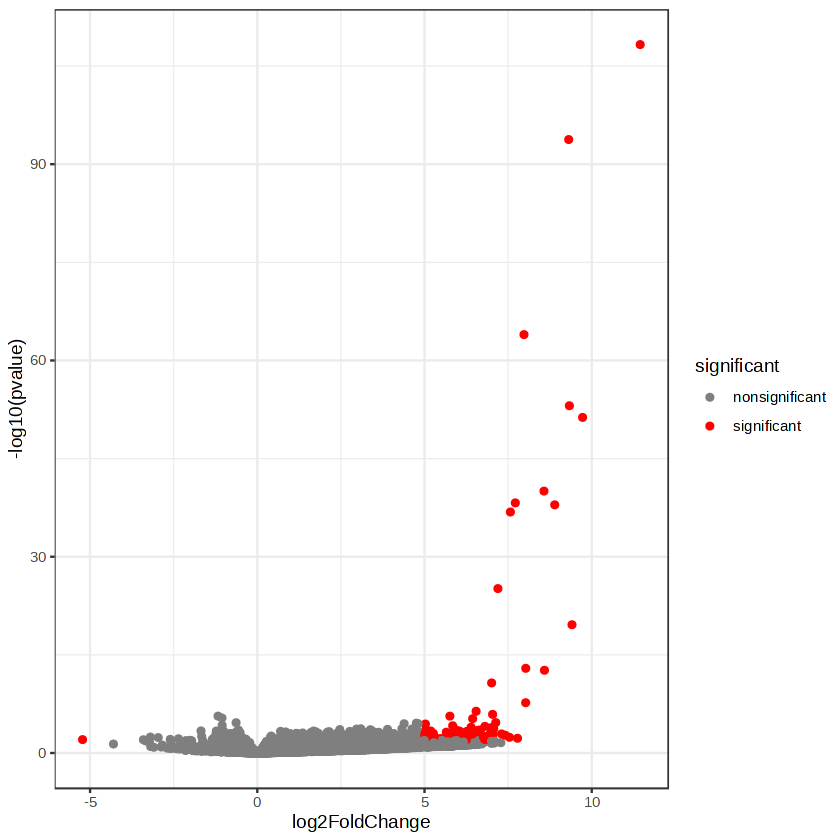

In [7]:
#plot differential expression by sex
res <- res[!is.na(res$padj), ]
res$significant <- ifelse(res$pvalue < 0.01 & abs(res$log2FoldChange) > 5, "significant", "nonsignificant")
res$Symbol <- rowData(dds)[rownames(res), "Symbol"]
ggplot(data.frame(res), aes(x = log2FoldChange, y = -log10(pvalue), color = significant)) + geom_point(pch = 19) + theme_bw() + 
scale_color_manual(values = c("significant" = 'red', "nonsignificant" = 'grey50'))



clusterProfiler v3.18.1  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:biomaRt’:

    select


The following object is masked from ‘package:igraph’:

    simplify


The following object is masked from ‘package:IRanges’:

    slice


The following object is masked from ‘package:S4Vectors’:

    rename


The following object is masked from ‘package:stats’:

    filter


preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0% of the list).
The order of those tied genes will be arbitrary, which may

,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalues,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
chrYq11,chrYq11,chrYq11,21,0.9724973,2.425512,2.498635e-08,6.421492e-06,6.233437e-06,15,"tags=48%, list=0%, signal=48%",DDX3Y/UTY/EIF1AY/KDM5D/USP9Y/TXLNGY/TTTY14/NLGN4Y/TMSB4Y/GYG2P1
chrYp11,chrYp11,chrYp11,18,0.9582827,2.331530,8.093992e-07,1.040078e-04,1.009619e-04,14,"tags=28%, list=0%, signal=28%",RPS4Y1/ZFY/LINC00278/ZFY-AS1/TBL1Y
chrXp22,chrXp22,chrXp22,120,-0.4031798,-1.936142,3.013094e-06,2.581218e-04,2.505626e-04,568,"tags=13%, list=3%, signal=13%",PIR/EIF2S3/SAT1/EEF1B2P3/PRPS2/SYAP1/SLC25A6/TXLNG/TRAPPC2/ARSL/ZFX/EIF1AX/ZRSR2/OFD1/PUDP/PNPLA4
chr17q25,chr17q25,chr17q25,192,-0.3153330,-1.559270,5.930449e-05,3.810314e-03,3.698728e-03,2806,"tags=25%, list=13%, signal=22%",CBX2/GRB2/AFMID/SPHK1/MCRIP1/GPS1/NT5C/RFNG/NPLOC4/FN3KRP/DUS1L/MRPS7/WDR45B/EIF4A3/CCDC137/MIF4GD/SLC9A3R1/CENPX/WBP2/NDUFAF8/SUMO2/ANAPC11/RHBDF2/FAM104A/CHMP6/GALK1/ATP5PD/SNHG16/TSEN54/ARL16/HGS/UBALD2/ARHGDIA/METTL23/TRIM47/UNK/ATF4P3/MRPL58/ALYREF/CDC42EP4/LLGL2/H3-3B/CDR2L/ARMC7/SOCS3/SEPTIN9/RPL38/ACTG1


wrong orderBy parameter; set to default `orderBy = "x"`



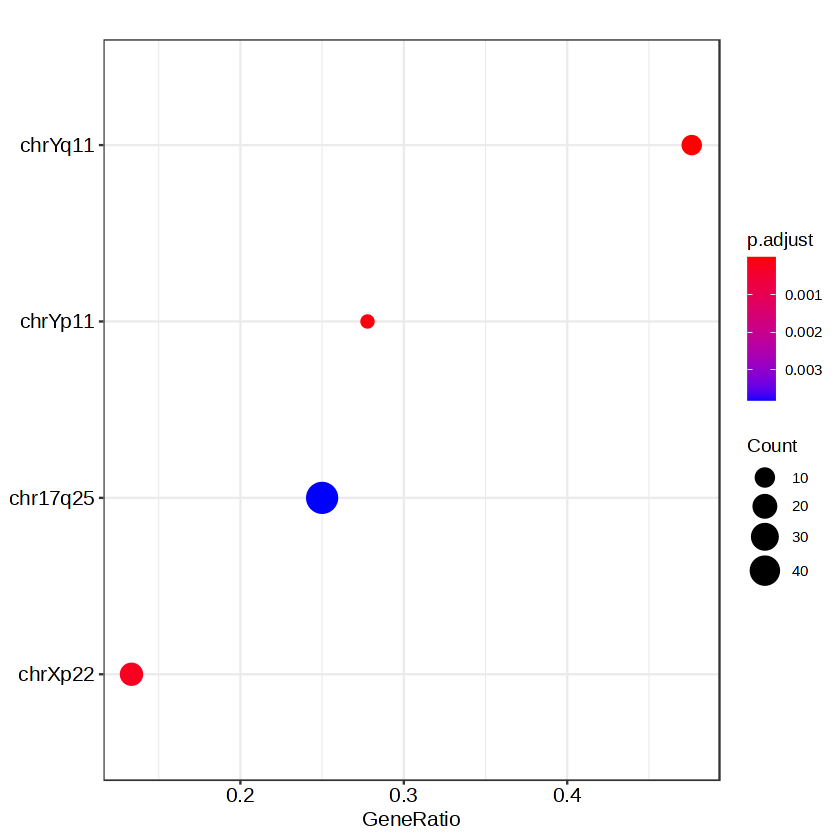

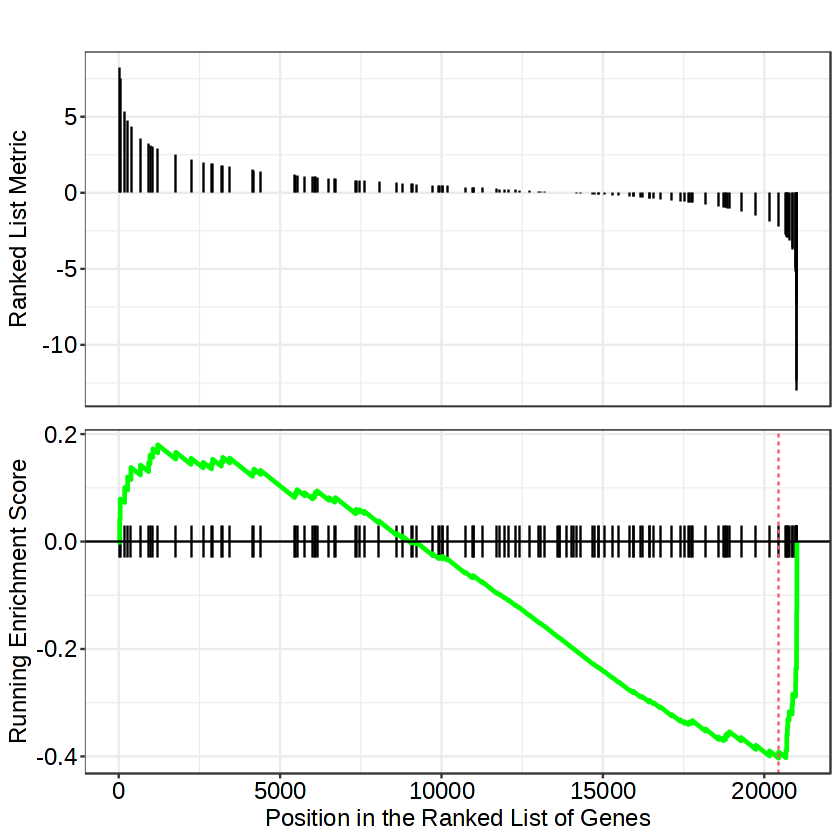

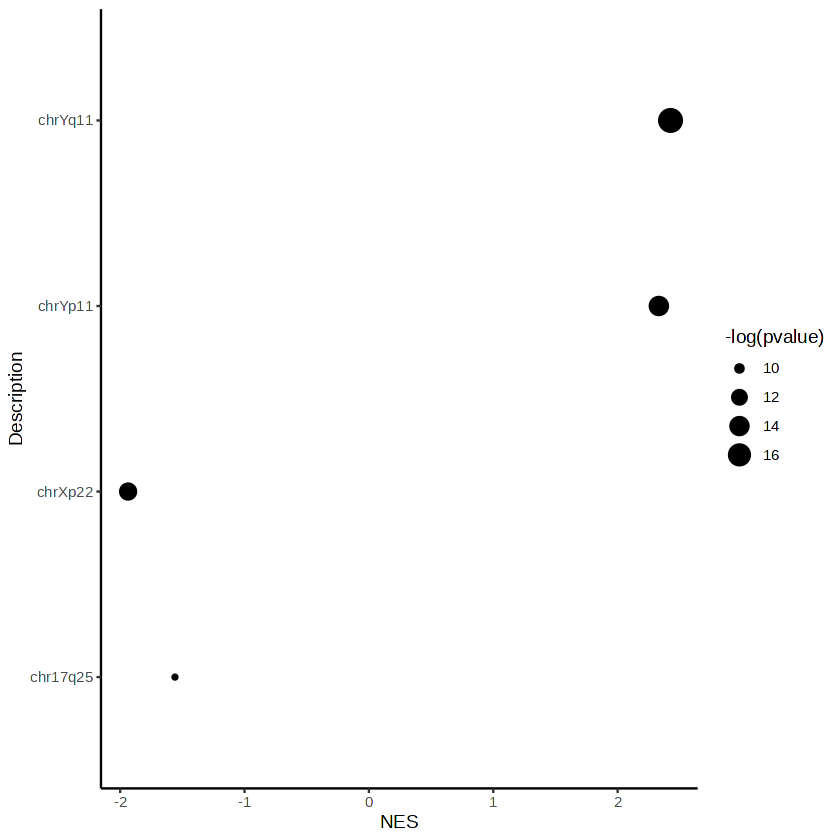

In [8]:
#what are some genes that are different in women
res_df <- data.frame(res[order(res$log2FoldChange), ])
rank <- -log(res_df$pvalue)*sign(res_df$log2FoldChange)
names(rank) <- res_df$Symbol
rank <- rank[order(rank, decreasing = TRUE)]
rank <- rank[!duplicated(names(rank))]
#plot some M vs F enrichments..
library(clusterProfiler)
t2g <- msigdbr::msigdbr(category = 'C1') #this will give us positional genesets so we can look at chromosome enrichment (chrX and chrY)
t2g <- data.frame("TERM" = t2g$gs_name, "GENE" = t2g$gene_symbol)
gsea_out<- clusterProfiler::GSEA(geneList =rank, TERM2GENE = t2g)
head(gsea_out@result)
clusterProfiler::dotplot(gsea_out)
clusterProfiler::gseaplot(gsea_out, geneSetID = c("chrXp22"))
ggplot(gsea_out@result, aes(x = NES, y = Description,  size = -log(pvalue)), aes(x=x, y=y)) + geom_point(pch=19) +  theme_classic()

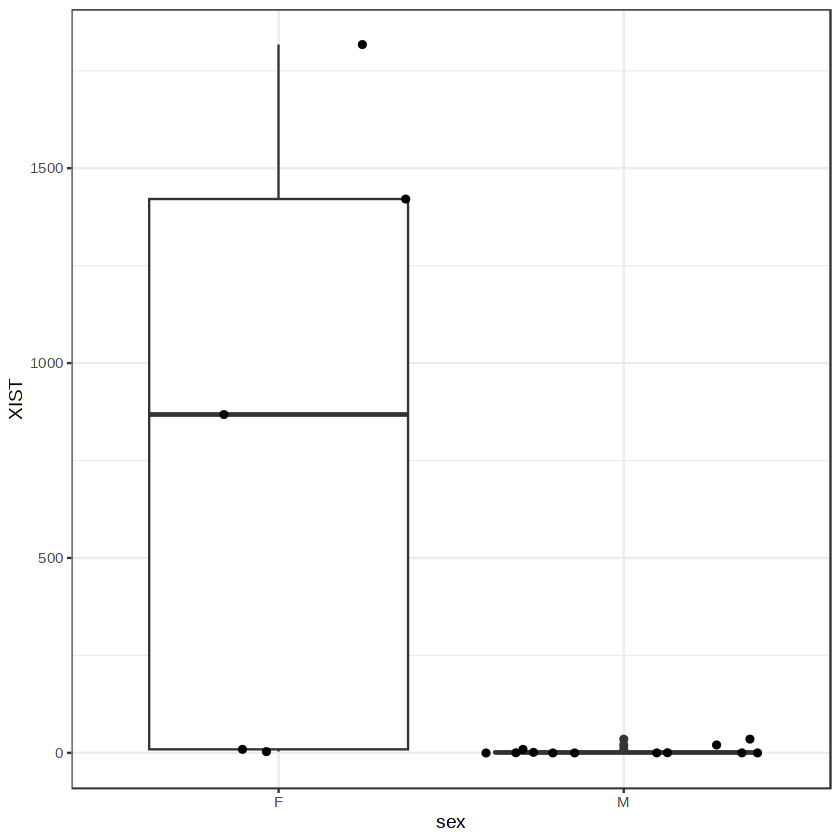

In [9]:
#variance stabilising transform
vsd <- vst(dds, blind=FALSE)
colnames(vsd) <- dds$donor
ggplot(data.frame("XIST" = assay(dds)[rowData(dds)$Symbol %in% 'XIST', ], "sex" = dds$sex), aes(x= sex, y = XIST)) + geom_boxplot() + geom_jitter() + theme_bw()

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.8 GiB”
Creating Basis Matrix adjusted for maximal variance weight

Used 1458 common genes...

Used 46 cell types in deconvolution...

WSSS_A_KID10311476 has common genes 936 ...

WNNLS Converged at iteration 3

WSSS_A_KID10311478 has common genes 672 ...

WNNLS Converged at iteration 1

WSSS_A_KID10311479 has common genes 979 ...

WNNLS Converged at iteration 12

WSSS_A_KID10311480 has common genes 1218 ...

WNNLS Converged at iteration 7

WSSS_A_KID10311481 has common genes 1230 ...

WNNLS Converged at iteration 3

WSSS_A_KID10311482 has common genes 1240 ...

WNNLS Converged at iteration 8

WSSS_A_KID10311484 has common genes 906 ...

WNNLS Converged at iteration 2

WSSS_A_KID10311485 has common genes 1210 ...

WNNLS Converged at iteration 6

WSSS_A_KID10311487 has common genes 791 ...

WNNLS Converged at iteration 6

WSSS_A_KID10311489 has common genes 1388 ...

WNNLS Converged at iteration 20


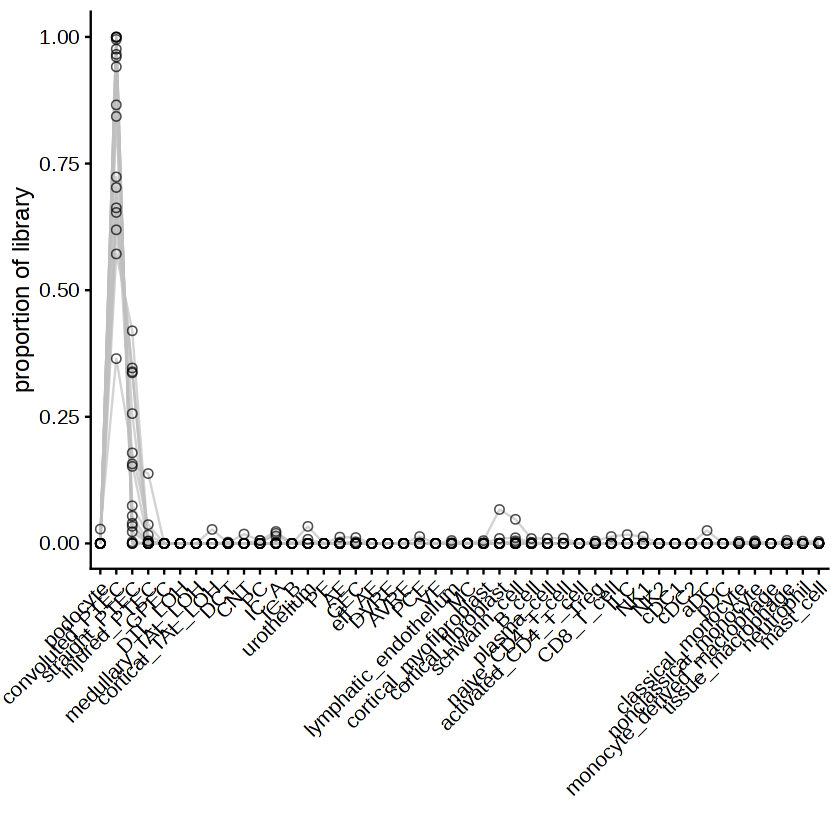

In [10]:
#perform a deconvolution analysis of these samples
#devtools::install_github("meichendong/SCDC")
#reference profiles
adata <- sc$read_h5ad("data/annotated/public_kidney.h5ad") #our annotated kidney data...
#test bulk profiles
dds <- dds[!duplicated(rowData(dds)$Symbol), ]
bulk_data <- data.frame(assay(dds), row.names = rowData(dds)$Symbol)
idx <- intersect(rownames(bulk_data), adata$var_names$values)
adata = py_eval('r.adata[:, r.idx]' )
bulk_data <- bulk_data[idx, ]

library(SCDC) #this works quite well.
sc_eset <- getESET(t(adata$layers['counts']), fdata = adata$var, pdata = adata$obs)
rownames(sc_eset) <- adata$var$Symbol
bulk_eset <- ExpressionSet(as.matrix(bulk_data), fdata = adata$var, pdata = colData(dds))
props <- SCDC_prop( bulk_eset, sc_eset, ct.varname = "cell_type", sample = "channel", ct.sub = unique(sc_eset$cell_type))
celltype_proportions <- props$prop.est.mvw
#the order should respect the cat orders we put in the annotatin script for public data...
celltype_proportions = celltype_proportions[, levels(adata$obs$cell_type)]

celltype_proportions <- reshape::melt(celltype_proportions)
celltype_proportions$X2 <- factor(celltype_proportions$X2, levels = unique(celltype_proportions$X2))
ggplot(reshape::melt(celltype_proportions), aes(x = X2, y = value, group = X1)) + 
  geom_line(alpha = 0.7, color = 'grey') + geom_point(pch = 21, size = 2, alpha = 0.7) +   theme_cowplot() + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1, color = 'black'), legend.position = 'none') + 
  xlab("") + ylab("proportion of library")


Using X1, X2 as id variables



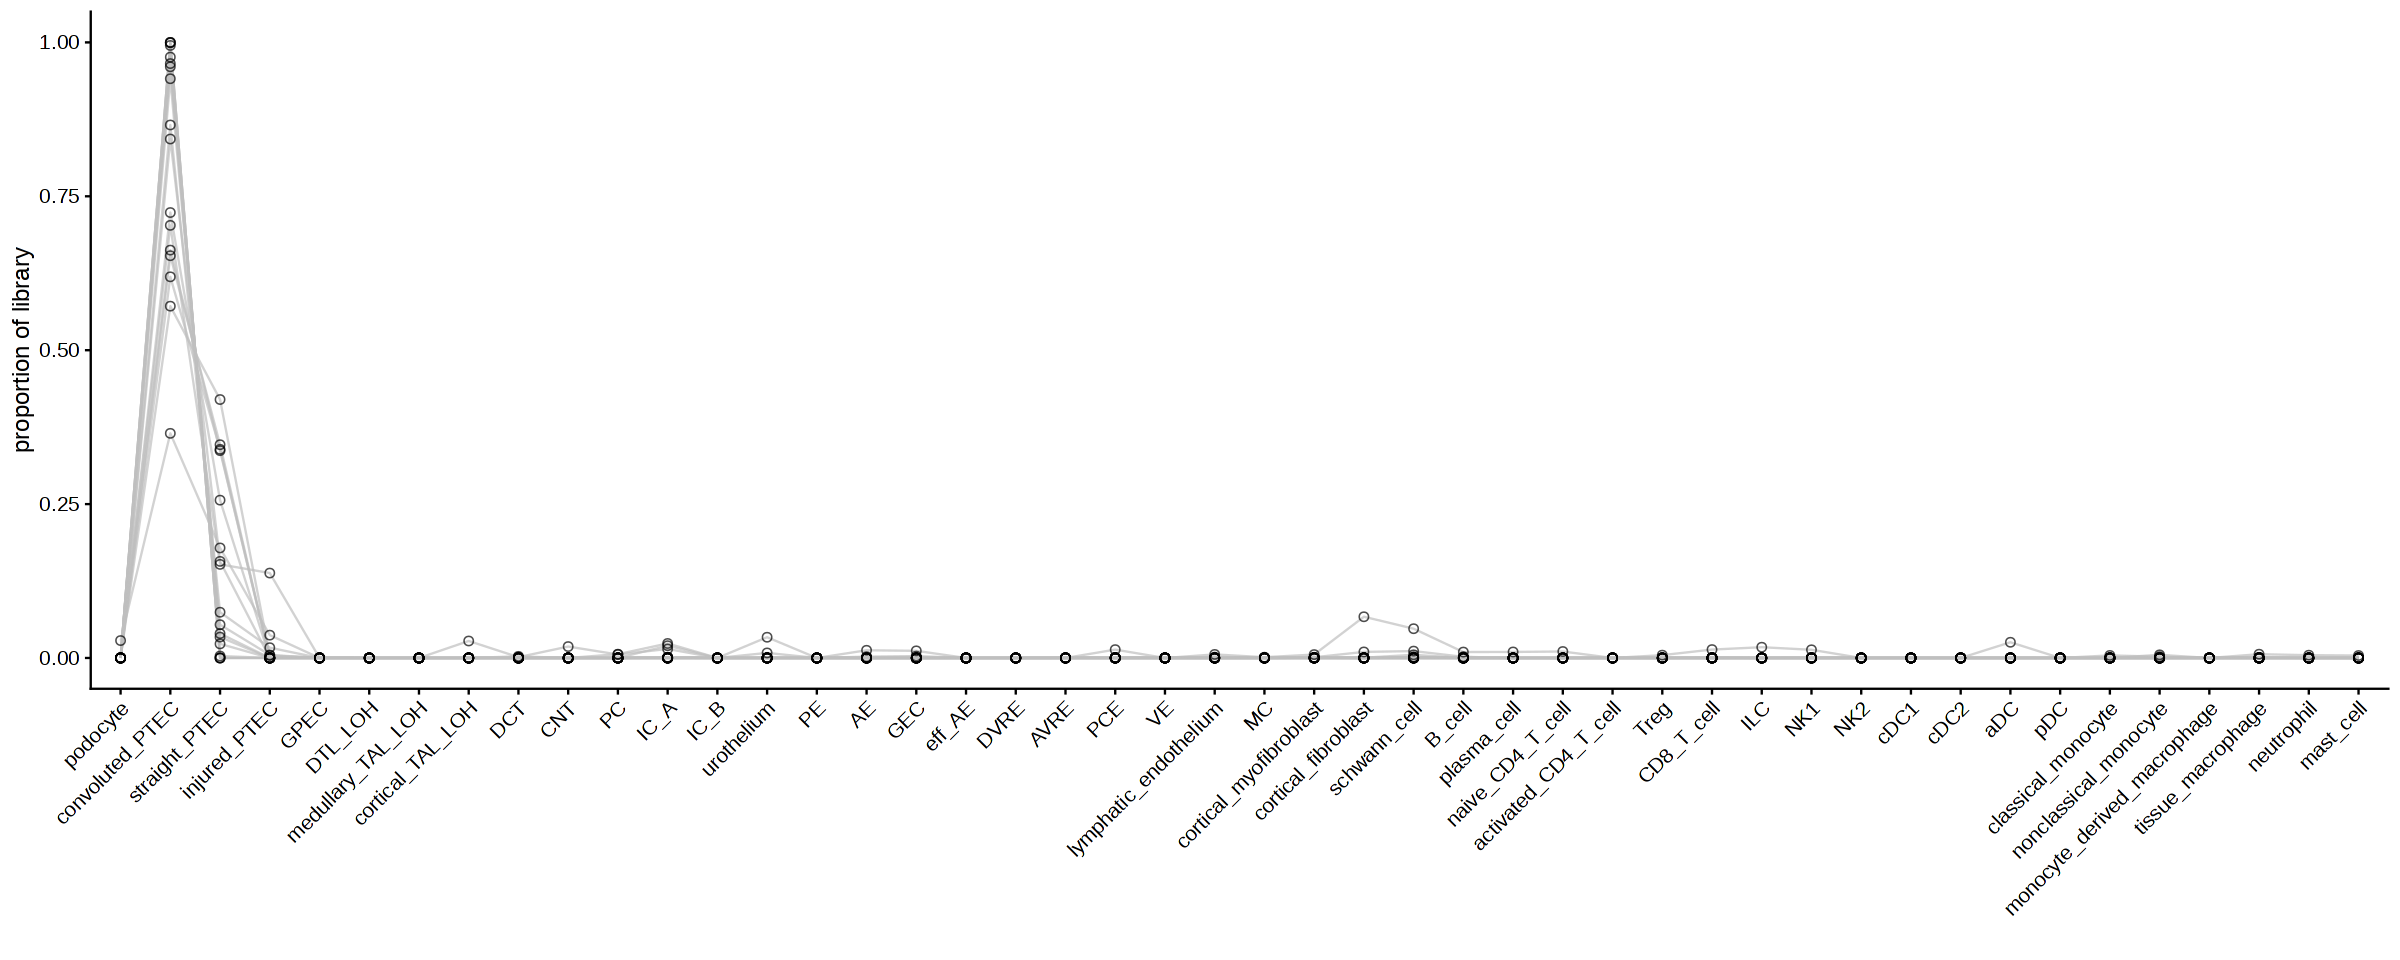

In [12]:
options(repr.plot.width = 20, repr.plot.height = 8)
proportion_plot = ggplot(reshape::melt(celltype_proportions), aes(x = X2, y = value, group = X1)) + 
  geom_line(alpha = 0.7, color = 'grey') + geom_point(pch = 21, size = 2, alpha = 0.7) +   theme_cowplot() + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1, color = 'black'), legend.position = 'none') + 
  xlab("") + ylab("proportion of library")
proportion_plot

In [15]:
pdf(file="~/ben_lustre/current_projects/kidney_glomTI_response/figures/bulk_PTEC_deconv.pdf",
   width = 15, height= 8 
   )
proportion_plot
dev.off()

png 
  2

In [16]:
celltype_proportions

X1,X2,value
<fct>,<fct>,<dbl>
WSSS_A_KID10311476,podocyte,0.0000000000
WSSS_A_KID10311478,podocyte,0.0000000000
WSSS_A_KID10311479,podocyte,0.0000000000
WSSS_A_KID10311480,podocyte,0.0000000000
WSSS_A_KID10311481,podocyte,0.0000000000
WSSS_A_KID10311482,podocyte,0.0000000000
WSSS_A_KID10311484,podocyte,0.0000000000
WSSS_A_KID10311485,podocyte,0.0000000000
WSSS_A_KID10311487,podocyte,0.0000000000


In [19]:
head(metadata)

,donor,date,submission_channel,sequencing_sample_name,sanger_ID,tissue,poor_QC,experiment,tissue_dissociation_processing_batch,sequencing_batch,⋯,perturbation_timepoint,age,sex,CASM_ID,Status,cellranger_SOC,HMDMC,irods_dir,irods_ID,X10xDIR
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,⋯,<int>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>
K232,K232,5_7_21,bulk_proximal_tubule,K232 PT,WSSS_A_KID10311476,bulk_proximal_tubule,FALSE,bulk_RNA_seq,bulk_RNA_seq_batch_1,RNA_seq_batch_6,⋯,NA,37,M,NA,Sequenced,FALSE,HMDMC 18/064,NA,NA,
K241,K241,5_7_21,bulk_proximal_tubule,K241 PT,WSSS_A_KID10311478,bulk_proximal_tubule,FALSE,bulk_RNA_seq,bulk_RNA_seq_batch_1,RNA_seq_batch_6,⋯,NA,69,F,NA,Sequenced,FALSE,HMDMC 18/064,NA,NA,
K245,K245,5_7_21,bulk_proximal_tubule,K245 PT,WSSS_A_KID10311479,bulk_proximal_tubule,FALSE,bulk_RNA_seq,bulk_RNA_seq_batch_1,RNA_seq_batch_6,⋯,NA,51,M,NA,Sequenced,FALSE,HMDMC 18/064,NA,NA,
K247,K247,5_7_21,bulk_proximal_tubule,K247 PT,WSSS_A_KID10311480,bulk_proximal_tubule,FALSE,bulk_RNA_seq,bulk_RNA_seq_batch_1,RNA_seq_batch_6,⋯,NA,59,F,NA,Sequenced,FALSE,HMDMC 18/064,NA,NA,
K250,K250,5_7_21,bulk_proximal_tubule,K250 PT,WSSS_A_KID10311481,bulk_proximal_tubule,FALSE,bulk_RNA_seq,bulk_RNA_seq_batch_1,RNA_seq_batch_6,⋯,NA,77,M,NA,Sequenced,FALSE,HMDMC 18/064,NA,NA,
K251,K251,5_7_21,bulk_proximal_tubule,K251 PT,WSSS_A_KID10311482,bulk_proximal_tubule,FALSE,bulk_RNA_seq,bulk_RNA_seq_batch_1,RNA_seq_batch_6,⋯,NA,77,M,NA,Sequenced,FALSE,HMDMC 18/064,NA,NA,


In [20]:
rownames(metadata) = metadata$sanger_ID
celltype_proportions$X1 =  metadata[celltype_proportions$X1, "donor"]

Using X1, X2 as id variables



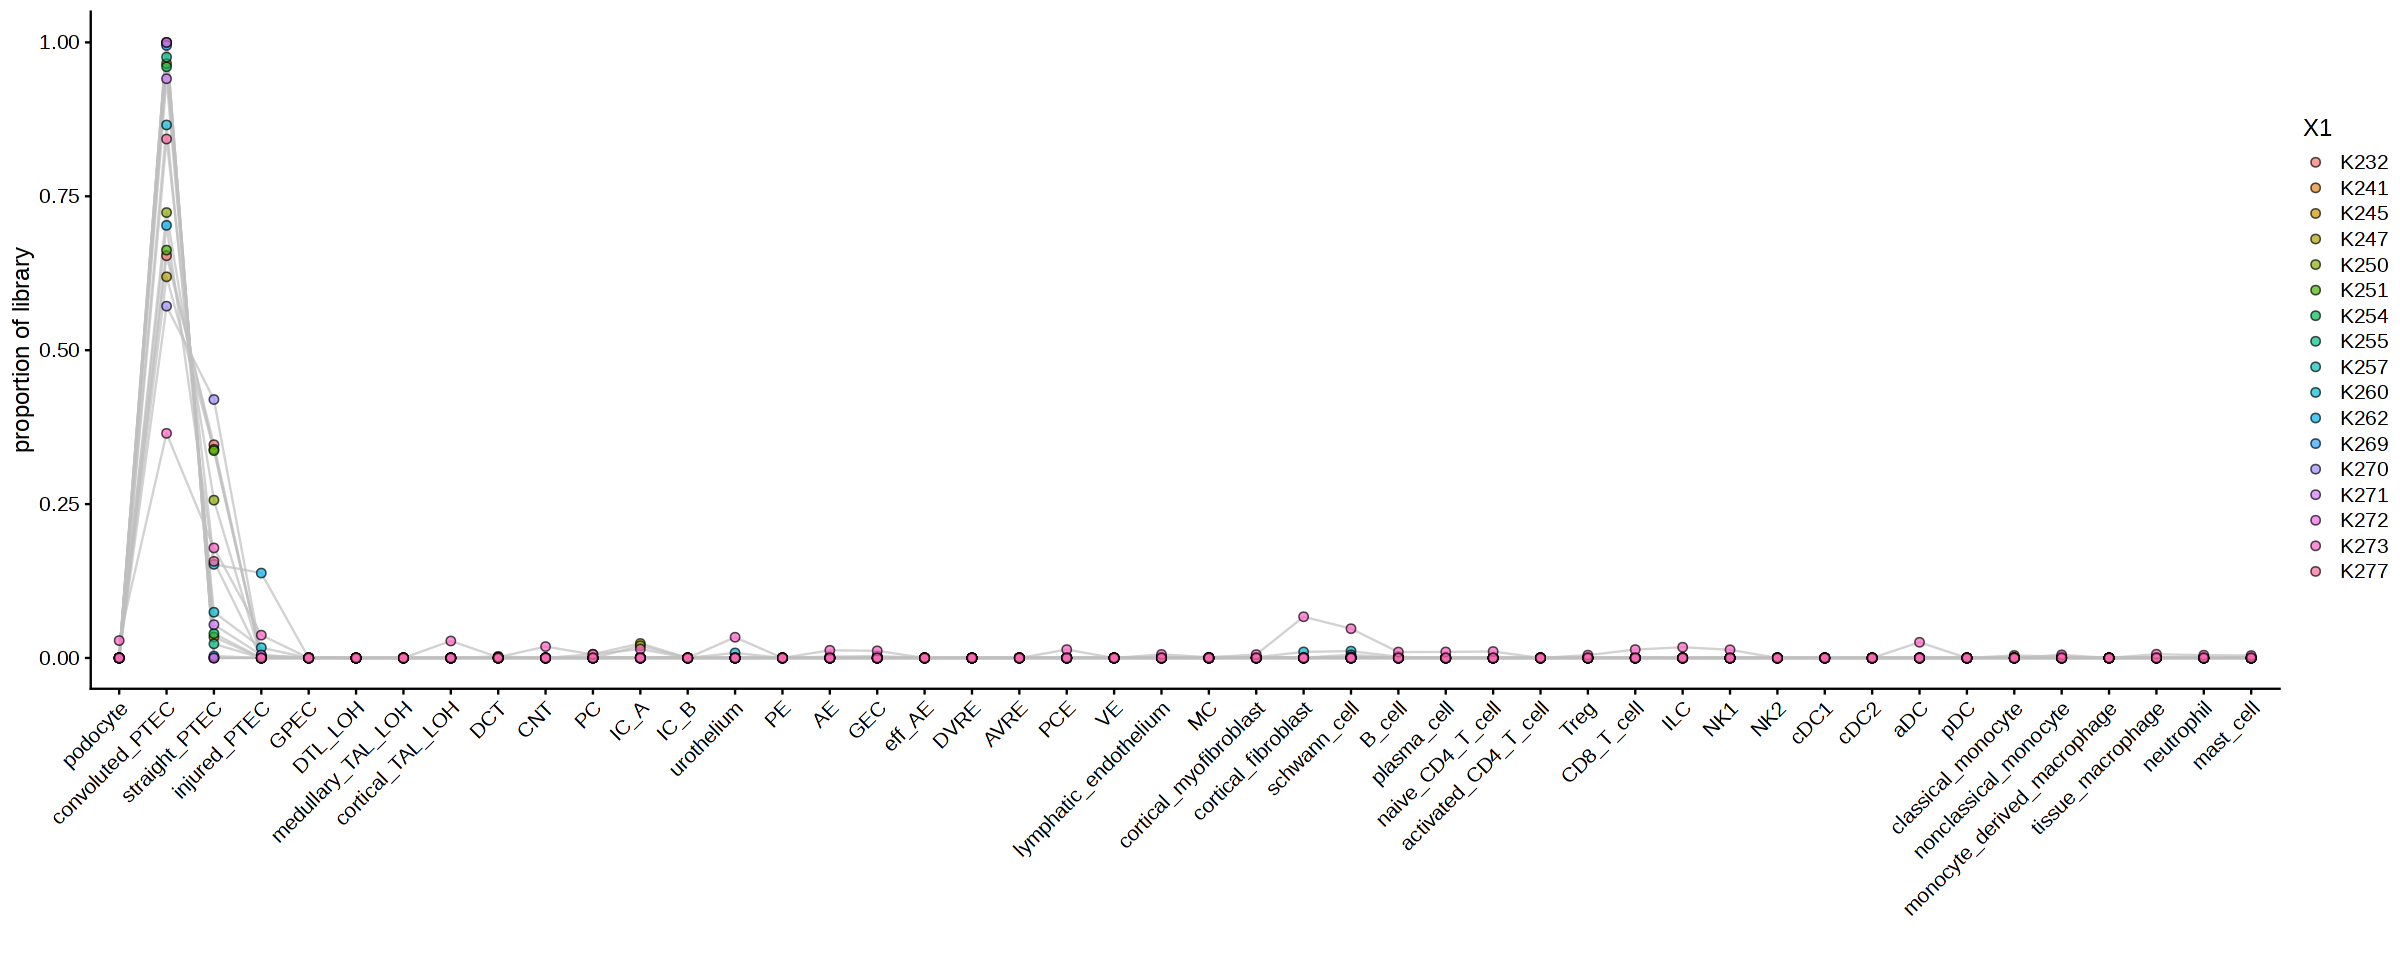

In [23]:
proportion_plot = ggplot(reshape::melt(celltype_proportions), aes(x = X2, y = value, group = X1, fill = X1)) + 
  geom_line(alpha = 0.7, color = 'grey') + geom_point(pch = 21, size = 2, alpha = 0.7) +   theme_cowplot() + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1, color = 'black')) + 
  xlab("") + ylab("proportion of library")
proportion_plot